In [1]:
import confirm.berrylib.util as util
util.setup_nb(pretty=False)

import time
from scipy.special import logit, expit
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import jax.numpy as jnp
import warnings
import confirm.berrylib.fast_inla as fast_inla
import confirm.mini_imprint.binomial as binomial
import confirm.mini_imprint.binomial_tuning as binomial_tuning
import confirm.mini_imprint.grid as grid
import confirm.mini_imprint.execute as execute
from rich import print as rprint

import jax

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_arms = 3
n_arm_samples = 35
n_theta_1d = 16
theta_min = -3.5
theta_max = 1.0

null_hypos = [
    grid.HyperPlane(-np.identity(n_arms)[i], -logit(0.1)) for i in range(n_arms)
]
theta, radii = grid.cartesian_gridpts(
    np.full(n_arms, theta_min), np.full(n_arms, theta_max), np.full(n_arms, n_theta_1d)
)
g_raw = grid.build_grid(theta, radii)

In [3]:
g_raw.n_tiles

4096

In [4]:
fi = fast_inla.FastINLA(n_arms=n_arms)
test_table = binomial_tuning.build_lookup_table(n_arms, n_arm_samples, fi.test_inference)

In [5]:

simulator = binomial_tuning.binomial_tuner(lambda data: binomial_tuning.lookup(test_table, data[...,0]))
accumulator = binomial.binomial_accumulator(
    lambda data, cv: binomial_tuning.lookup(test_table, data[..., 0]) > cv
)

In [6]:
target_grid_cost = 0.001
target_sim_cost = 0.001
target_alpha = 0.15

In [7]:
g = grid.prune(grid.intersect_grid(g_raw, null_hypos))
g.n_tiles

3185

In [9]:
iter_max = 50
init_nsims = 2000
g = grid.prune(grid.intersect_grid(g_raw, null_hypos))
target_nsims = np.full(g.n_tiles, init_nsims)
tuning_unfinished = np.ones(g.n_tiles, dtype=bool)
sim_cvs = np.empty(g.n_tiles, dtype=float)
typeI_sum = np.empty(g.n_tiles, dtype=float)
hob_upper = np.empty(g.n_tiles, dtype=float)

seed = 1
for II in range(iter_max):
    holderq = 6
    # TODO: partial update here, need to batch!
    # TODO: just move this to the refinement code!!
    pointwise_target_alpha = binomial.invert_bound(
        target_alpha, g.theta_tiles, g.vertices, n_arm_samples, holderq
    )

    # TODO: combine the two simulator functions.
    np.random.seed(seed)
    updated_tiles = tuning_unfinished.copy()
    while np.any(tuning_unfinished):
        nsims = np.min(target_nsims[tuning_unfinished])
        this_iter = (target_nsims == nsims) & tuning_unfinished
        sim_cvs[this_iter] = binomial_tuning.chunked_tune(
            grid.index_grid(g, this_iter),
            simulator,
            pointwise_target_alpha[this_iter],
            nsims,
            n_arm_samples,
        )
        tuning_unfinished[this_iter] = False
    overall_cv = np.max(sim_cvs)

    np.random.seed(seed)
    checking_unfinished = updated_tiles.copy()
    while np.any(checking_unfinished):
        nsims = np.min(target_nsims[checking_unfinished])
        this_iter = (target_nsims == nsims) & checking_unfinished
        typeI_sum[this_iter] = execute.chunked_simulate(
            grid.index_grid(g, this_iter), accumulator, overall_cv, nsims, n_arm_samples
        )
        checking_unfinished[this_iter] = False

    # TODO: partial update here, systematic way to do this.
    # TODO: jit zero_order_bound
    typeI_est, typeI_CI = binomial.zero_order_bound(typeI_sum, target_nsims, 0.01, 1.0)
    typeI_bound = typeI_est + typeI_CI
    hob_upper = binomial.holder_odi_bound(
        typeI_bound, g.theta_tiles, g.vertices, n_arm_samples, holderq
    )
    sim_cost = typeI_CI
    hob_theory_cost = target_alpha - pointwise_target_alpha
    hob_empirical_cost = hob_upper - typeI_bound

    worst_tile = np.argmax(sim_cvs)
    which_refine = (
        hob_theory_cost > max(0.9 * hob_theory_cost[worst_tile], target_grid_cost)
    ) & ((hob_upper > 0.9 * hob_upper[worst_tile]) | (sim_cvs == sim_cvs[worst_tile]))
    which_more_sims = (typeI_CI > max(0.9 * typeI_CI[worst_tile], target_sim_cost)) & (
        (typeI_bound > 0.9 * hob_upper[worst_tile]) | (sim_cvs == sim_cvs[worst_tile])
    )

    report = dict(
        II=II,
        overall_cv=overall_cv,
        n_tiles=g.n_tiles,
        n_refine=np.sum(which_refine),
        n_more_sims=np.sum(which_more_sims),
        grid_cost=f"{hob_empirical_cost[worst_tile]:.4f}",
        sim_cost=f"{sim_cost[worst_tile]:.4f}",
    )
    rprint(report)

    # plt.figure(figsize=(4,4))
    # plt.scatter(g.theta_tiles[:,0], g.theta_tiles[:, 1], c=typeI_est, s=20)
    # plt.colorbar()
    # plt.show()

    if np.sum(which_refine) > 0 or np.sum(which_more_sims) > 0:
        target_nsims[which_more_sims] *= 2
        tuning_unfinished[which_more_sims] = True

        refine_tile_idxs = np.where(which_refine)[0]
        refine_gridpt_idxs = g.grid_pt_idx[refine_tile_idxs]
        # refine_target_nsims = target_nsims[refine_tile_idxs]
        new_thetas, new_radii, unrefined_grid, keep_tile_idxs = grid.refine_grid(
            g, refine_gridpt_idxs
        )
        new_grid = grid.prune(grid.build_grid(new_thetas, new_radii, g.null_hypos))
        nearest_parent_tiles = scipy.spatial.KDTree(g.theta_tiles).query(
            new_grid.theta_tiles, k=2
        )
        new_target_nsims = np.max(target_nsims[nearest_parent_tiles[1]], axis=1).astype(
            int
        )

        old_g = g
        g = grid.concat_grids(unrefined_grid, new_grid)

        target_nsims = np.concatenate([target_nsims[keep_tile_idxs], new_target_nsims])
        tuning_unfinished = np.concatenate(
            [tuning_unfinished[keep_tile_idxs], np.ones(new_grid.n_tiles, dtype=bool)]
        )
        typeI_sum = np.concatenate(
            [typeI_sum[keep_tile_idxs], np.zeros(new_grid.n_tiles, dtype=float)]
        )
        hob_upper = np.concatenate(
            [hob_upper[keep_tile_idxs], np.empty(new_grid.n_tiles, dtype=float)]
        )
        sim_cvs = np.concatenate(
            [sim_cvs[keep_tile_idxs], np.zeros(new_grid.n_tiles, dtype=float)]
        )
    else:
        print("done!")
        break

%load_ext line_profiler
%lprun -T prof.txt -f grid.build_grid -f grid.prune -f binomial._calc_Cqpp -f f -f binomial_tuning.chunked_tune -f execute.chunked_simulate f()

{
    'II': 0,
    'overall_cv': 0.9999433449435139,
    'n_tiles': 3185,
    'n_refine': DeviceArray(5, dtype=int64),
    'n_more_sims': DeviceArray(1, dtype=int64),
    'grid_cost': '0.1985',
    'sim_cost': '0.0052'
}

{
    'II': 1,
    'overall_cv': 0.99992445348847,
    'n_tiles': 3220,
    'n_refine': DeviceArray(66, dtype=int64),
    'n_more_sims': DeviceArray(1, dtype=int64),
    'grid_cost': '0.1635',
    'sim_cost': '0.0045'
}

{
    'II': 2,
    'overall_cv': 0.999866298740245,
    'n_tiles': 3682,
    'n_refine': DeviceArray(212, dtype=int64),
    'n_more_sims': DeviceArray(1, dtype=int64),
    'grid_cost': '0.1191',
    'sim_cost': '0.0032'
}

{
    'II': 3,
    'overall_cv': 0.9997672181515694,
    'n_tiles': 5460,
    'n_refine': DeviceArray(155, dtype=int64),
    'n_more_sims': DeviceArray(1, dtype=int64),
    'grid_cost': '0.0978',
    'sim_cost': '0.0032'
}

{
    'II': 4,
    'overall_cv': 0.9997359654526813,
    'n_tiles': 6647,
    'n_refine': DeviceArray(436, dtype=int64),
    'n_more_sims': DeviceArray(1, dtype=int64),
    'grid_cost': '0.0855',
    'sim_cost': '0.0032'
}

{
    'II': 5,
    'overall_cv': 0.9995931788192733,
    'n_tiles': 9765,
    'n_refine': DeviceArray(1183, dtype=int64),
    'n_more_sims': DeviceArray(1, dtype=int64),
    'grid_cost': '0.0666',
    'sim_cost': '0.0023'
}

{
    'II': 6,
    'overall_cv': 0.999490806059448,
    'n_tiles': 18834,
    'n_refine': DeviceArray(401, dtype=int64),
    'n_more_sims': DeviceArray(1, dtype=int64),
    'grid_cost': '0.0556',
    'sim_cost': '0.0023'
}

{
    'II': 7,
    'overall_cv': 0.9988557559917002,
    'n_tiles': 22120,
    'n_refine': DeviceArray(565, dtype=int64),
    'n_more_sims': DeviceArray(1, dtype=int64),
    'grid_cost': '0.0523',
    'sim_cost': '0.0061'
}

{
    'II': 8,
    'overall_cv': 0.9987595684067953,
    'n_tiles': 24282,
    'n_refine': DeviceArray(621, dtype=int64),
    'n_more_sims': DeviceArray(2, dtype=int64),
    'grid_cost': '0.0446',
    'sim_cost': '0.0055'
}

{
    'II': 9,
    'overall_cv': 0.9986481352779226,
    'n_tiles': 27672,
    'n_refine': DeviceArray(831, dtype=int64),
    'n_more_sims': DeviceArray(67, dtype=int64),
    'grid_cost': '0.0393',
    'sim_cost': '0.0052'
}

{
    'II': 10,
    'overall_cv': 0.9976587924386348,
    'n_tiles': 33279,
    'n_refine': DeviceArray(1296, dtype=int64),
    'n_more_sims': DeviceArray(590, dtype=int64),
    'grid_cost': '0.0359',
    'sim_cost': '0.0031'
}

{
    'II': 11,
    'overall_cv': 0.9960356046658166,
    'n_tiles': 42658,
    'n_refine': DeviceArray(1975, dtype=int64),
    'n_more_sims': DeviceArray(2624, dtype=int64),
    'grid_cost': '0.0296',
    'sim_cost': '0.0040'
}

{
    'II': 12,
    'overall_cv': 0.9954605900957582,
    'n_tiles': 58631,
    'n_refine': DeviceArray(1150, dtype=int64),
    'n_more_sims': DeviceArray(5964, dtype=int64),
    'grid_cost': '0.0261',
    'sim_cost': '0.0025'
}

{
    'II': 13,
    'overall_cv': 0.9953569797705519,
    'n_tiles': 67194,
    'n_refine': DeviceArray(160, dtype=int64),
    'n_more_sims': DeviceArray(1, dtype=int64),
    'grid_cost': '0.0707',
    'sim_cost': '0.0051'
}

{
    'II': 14,
    'overall_cv': 0.9953255597012131,
    'n_tiles': 68314,
    'n_refine': DeviceArray(1522, dtype=int64),
    'n_more_sims': DeviceArray(10494, dtype=int64),
    'grid_cost': '0.0226',
    'sim_cost': '0.0024'
}

{
    'II': 15,
    'overall_cv': 0.9951789487053084,
    'n_tiles': 79435,
    'n_refine': DeviceArray(183, dtype=int64),
    'n_more_sims': DeviceArray(3, dtype=int64),
    'grid_cost': '0.0687',
    'sim_cost': '0.0025'
}

{
    'II': 16,
    'overall_cv': 0.9945718583016021,
    'n_tiles': 80716,
    'n_refine': DeviceArray(1781, dtype=int64),
    'n_more_sims': DeviceArray(16570, dtype=int64),
    'grid_cost': '0.0198',
    'sim_cost': '0.0022'
}

{
    'II': 17,
    'overall_cv': 0.9944184822106266,
    'n_tiles': 93231,
    'n_refine': DeviceArray(173, dtype=int64),
    'n_more_sims': DeviceArray(1, dtype=int64),
    'grid_cost': '0.0698',
    'sim_cost': '0.0025'
}

{
    'II': 18,
    'overall_cv': 0.9932252869809425,
    'n_tiles': 94442,
    'n_refine': DeviceArray(519, dtype=int64),
    'n_more_sims': DeviceArray(2, dtype=int64),
    'grid_cost': '0.0644',
    'sim_cost': '0.0024'
}

{
    'II': 19,
    'overall_cv': 0.9929738936479922,
    'n_tiles': 98075,
    'n_refine': DeviceArray(1678, dtype=int64),
    'n_more_sims': DeviceArray(45, dtype=int64),
    'grid_cost': '0.0348',
    'sim_cost': '0.0019'
}

{
    'II': 20,
    'overall_cv': 0.9929717607175813,
    'n_tiles': 103921,
    'n_refine': DeviceArray(748, dtype=int64),
    'n_more_sims': DeviceArray(1280, dtype=int64),
    'grid_cost': '0.0564',
    'sim_cost': '0.0016'
}

{
    'II': 21,
    'overall_cv': 0.9927870015382633,
    'n_tiles': 109169,
    'n_refine': DeviceArray(4606, dtype=int64),
    'n_more_sims': DeviceArray(350, dtype=int64),
    'grid_cost': '0.0317',
    'sim_cost': '0.0018'
}

{
    'II': 22,
    'overall_cv': 0.9904096400173534,
    'n_tiles': 133367,
    'n_refine': DeviceArray(542, dtype=int64),
    'n_more_sims': DeviceArray(6973, dtype=int64),
    'grid_cost': '0.0247',
    'sim_cost': '0.0047'
}

{
    'II': 23,
    'overall_cv': 0.9903227986087999,
    'n_tiles': 138522,
    'n_refine': DeviceArray(19664, dtype=int64),
    'n_more_sims': DeviceArray(3128, dtype=int64),
    'grid_cost': '0.0228',
    'sim_cost': '0.0052'
}

{
    'II': 24,
    'overall_cv': 0.990320131143711,
    'n_tiles': 283296,
    'n_refine': DeviceArray(11398, dtype=int64),
    'n_more_sims': DeviceArray(13852, dtype=int64),
    'grid_cost': '0.0300',
    'sim_cost': '0.0025'
}

{
    'II': 25,
    'overall_cv': 0.9871989245281456,
    'n_tiles': 352219,
    'n_refine': DeviceArray(33181, dtype=int64),
    'n_more_sims': DeviceArray(6249, dtype=int64),
    'grid_cost': '0.0178',
    'sim_cost': '0.0010'
}

KeyboardInterrupt: 

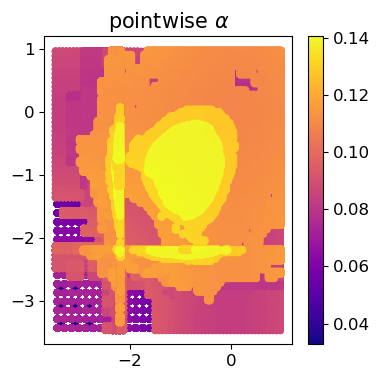

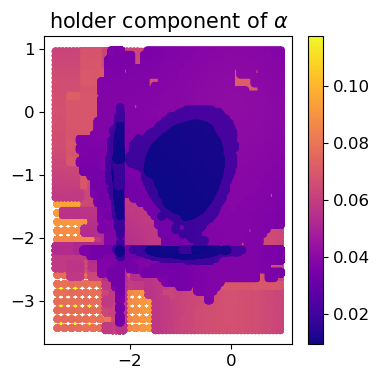

ValueError: 'c' argument has 352219 elements, which is inconsistent with 'x' and 'y' with size 546097.

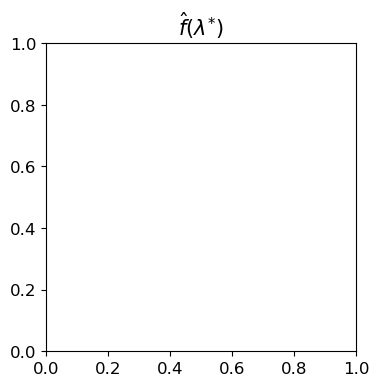

In [10]:
%matplotlib inline
plt.figure(figsize=(4,4))
plt.title(r'pointwise $\alpha$')
plt.scatter(g.theta_tiles[:,0], g.theta_tiles[:, 1], c=pointwise_target_alpha, s=20)
plt.colorbar()
plt.show()

hob = binomial.holder_odi_bound(
    np.full(g.n_tiles, pointwise_target_alpha),
    g.theta_tiles,
    g.vertices,
    n_arm_samples,
    holderq,
)
plt.figure(figsize=(4,4))
plt.title(r'holder component of $\alpha$')
plt.scatter(g.theta_tiles[:,0], g.theta_tiles[:, 1], c=hob - pointwise_target_alpha, s=20)
plt.colorbar()
plt.show()

plt.figure(figsize=(4,4))
plt.title(r'$\hat{f}(\lambda^{*})$')
plt.scatter(g.theta_tiles[:,0], g.theta_tiles[:, 1], c=typeI_est, s=20)
plt.colorbar()
plt.show()
# plt.figure(figsize=(4,4))
# plt.scatter(g.theta_tiles[:,0], g.theta_tiles[:, 1], c=which_more_sims, s=20)
# plt.colorbar()
# plt.show()

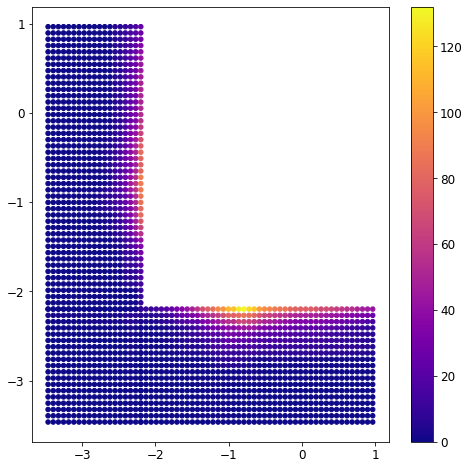

In [24]:
%matplotlib inline 
plt.figure(figsize=(8,8))
plt.scatter(g.theta_tiles[:,0], g.theta_tiles[:, 1], c=typeI_sum, s=20)
plt.colorbar()
plt.show()

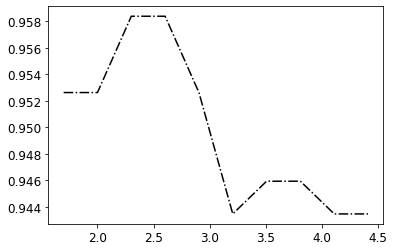

In [23]:
nsims_base = 50
cvs = []
ns = []
for i in range(10):
    nsims = nsims_base * (2 ** i)
    np.random.seed(0)
    samples = np.random.uniform(size=(nsims, n_arm_samples, n_arms))
    test_stats = simulator(g.theta_tiles, g.null_truth, samples)

    target_alpha = 0.2
    cv_idx = int(np.floor((nsims + 1) * target_alpha))
    nrejects_max = cv_idx - 1

# sorted_stats = np.sort(test_stats, axis=-1)
# sim_cv = sorted_stats[:, -cv_idx]
# np.partition lets us do this in O(n) time instead of O(n log n)
    partitioned_stats = np.partition(test_stats, nsims-cv_idx, axis=-1)
    sim_cv = partitioned_stats[:, -cv_idx]
    overall_cv = np.max(sim_cv)
    typeI_sum = np.sum(partitioned_stats[:, -cv_idx:] > overall_cv, axis=1)
    assert(np.all(typeI_sum <= nrejects_max))
    ns.append(nsims)
    cvs.append(overall_cv)
plt.plot(np.log10(ns), cvs, 'k-.')
plt.show()

In [ ]:
# uniform_samples = np.random.uniform(size=(nsims, n_arm_samples, n_arms))
# theta_tiles = g.theta_tiles
# null_truth = g.null_truth
# test_fnc = lambda data: binomial_tuning.lookup(test_table, data[...,0])

# max_sim_size, n_arm_samples, n_arms = uniform_samples.shape
# n_tiles = pointwise_alpha.shape[0]

# p_tiles = jax.scipy.special.expit(theta_tiles)
# y = jnp.sum(uniform_samples[None] < p_tiles[:, None, None, :], axis=2)
# y_flat = y.reshape((-1, n_arms))
# n_flat = jnp.full_like(y_flat, n_arm_samples)
# data = jnp.stack((y_flat, n_flat), axis=-1)
# test_stat = test_fnc(data).reshape(y.shape)

# max_null_test = jnp.max(
#     jnp.where(
#         null_truth[:, None],
#         test_stat,
#         np.min(test_stat, axis=-1, keepdims=True),
#     ),
#     axis=-1,
# )

# temp_sim_size = nsims
# cv_idx = jnp.floor((temp_sim_size + 1) * pointwise_alpha).astype(int)
# nrejects_max = cv_idx - 1
# partitioned_stats = np.partition(
#     max_null_test[:, :temp_sim_size], temp_sim_size - cv_idx, axis=-1
# )
# sim_cvs = partitioned_stats[np.arange(n_tiles), -cv_idx]

# t1s = np.sum(max_null_test[:, :] > sim_cvs[:, None], axis=1)
# half_nsims = nsims // 2
# half_t1s = np.sum(max_null_test[:, :half_nsims] > sim_cvs[:, None], axis=1)
# err = np.abs(half_t1s - (t1s / 2))
# pct_err = err / half_t1s
# pct_err
# np.random.seed(seed)
# sim_cvs = binomial_tuning.chunked_tune(g, simulator, pointwise_alpha, [nsims // 2, nsims], n_arm_samples)
# overall_cv = np.max(sim_cvs[-1])
# overall_cv